In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis

import random
import itertools

import os
from os import listdir
from os.path import isfile
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

import datetime
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm

from scipy import ndimage
from scipy import misc
from scipy import signal
import cv2
plt.ion()
plt.show()

import keras

from keras.layers import Input, Dense, Lambda, Layer, Conv2D, MaxPooling2D,UpSampling2D, concatenate
from keras.models import Model
from keras import backend as K
from keras import metrics


import collections
from collections import *

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


Using TensorFlow backend.


![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [2]:
!dir data/stage1_test

0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5
0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac
0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732
0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925
0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6
0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466
1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c
17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff
1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b
191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829
1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a
1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e
1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1
1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c
259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4
295682d9eb5acb5c1976a460c

In [3]:
submissionSample = pd.read_csv('data/stage1_sample_submission.csv')
submissionSample['ImageId'][0]

'0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5'

In [4]:
trainDir = 'data/stage1_train/'
testDir = 'data/stage1_test/'
unetSize = 256

In [5]:
fileIDs = listdir(trainDir)
testIDs = listdir(testDir)

In [6]:
def getFileImage(fileID, dd=trainDir):
    if not os.path.isfile(dd + fileID + '/images/'+ fileID + '.png'):
        print(f'Missing image file with ID {fileID}')
        return None
    else:
        return misc.imread(dd + fileID + '/images/'+fileID + '.png')

In [7]:
def drawContour(x):
    res = signal.convolve2d(x, [[1,1,1],[1,1,1],[1,1,1]], 'same')
    indices = np.where((res/255 < 9) & (x == 255)==True)
    x[indices[0],indices[1]] = 128
    return x

def getFileMasks(fileID):
    if not os.path.isdir(trainDir + fileID + '/masks/'):
        print(f'Missing mask file with ID {fileID}')
        return None
    else:
        theMask = None
        for mask in listdir(trainDir + fileID + '/masks/'):
            m = misc.imread(trainDir + fileID + '/masks/' + mask)
            m = drawContour(m)
            if theMask is None:
                theMask = m
            else:
                theMask = theMask + m
        return theMask
        


In [8]:
def splitMask(mask):
    print('jey')
    allMasks = []
    whitePixels = list(zip(*np.where(mask == 255)))
    while len(whitePixels) > 0 :
        pixels = getMaskPixels(whitePixels[0][0],whitePixels[0][1], mask)

        whitePixels = [p for p in whitePixels if p not in pixels]
        
        pixels = list(zip(*pixels))
        mask[pixels[0],pixels[1]] = 0
        
        m = np.zeros(mask.shape)
        m[pixels[0],pixels[1]] = 255
        allMasks.append(m)       
    return allMasks

# plt.imshow(mask, cmap = 'gray')
# for i in splitMask(mask.copy()):
#     plt.imshow(i, cmap = 'gray')
#     plt.figure()



In [9]:
def getMaskPixels(i,j, mask):
    result = np.zeros(mask.shape)
    result[i,j] = 255
    neighbors = [] + []

    toiterate = []

    toiterate.append((i,j))
    idx = 0
    while (idx < len(toiterate)):
#         print(toiterate)
        idxx = toiterate[idx][0]
        idxy = toiterate[idx][1]

        for newelem in [ (idxx+x,idxy+y) 
                    for x,y in itertools.product(range(-1,2), range(-1,2)) 
                    if  idxx+x < mask.shape[0] and idxx+x >= 0 and
                        idxy+y < mask.shape[1] and idxy+y >= 0 and
                        mask[idxx+x,idxy+y]==255 and not((idxx+x,idxy+y) in toiterate)]:
            toiterate.append(newelem)

        idx = idx+1
#         print(idx, len(toiterate))

    return toiterate
    
# getMaskPixels(1, 14, mask)

In [10]:
def getSubmissionForFile(fileID, masks):
    print(f'Found {len(masks)}')
    results = []
    for mask in masks:
        whitePixels = np.where(np.reshape(mask,-1, order='F')==255)[0]+1
#         print(len(whitePixels))
        result = []
        last = whitePixels[0]
        lastlen = 0

        for i in whitePixels:
            if i != last+1:
                result.append(lastlen+1)
                result.append(i)
                lastlen=0
            else:
                lastlen = lastlen+1
            last = i
        result.append(lastlen+1)
        results.append(result[1:])
    return results

In [11]:
# x =getSubmissionForFile('blah', [masks[2]])[0]
# np.sum([x[i] for i in range (len(x)) if i % 2  ])

In [12]:
# mask = masks[2]

# x = np.where(np.reshape(mask,-1, order='F')==255)[0]+1

# print(x[:5])
# # x.shape
# plt.figure(figsize=(18,18))
# plt.imshow(mask)
# # np.where(mask[2]==255)

In [13]:
# getSubmissionForFile('blah',  [getFileMasks(fileIDs[3])] )

In [14]:
def imgResize(img, newDimension):
    # todo: check both dimensions, or either
    if img.shape[0] > newDimension[0]: 
        X = cv2.resize(img,newDimension, cv2.INTER_AREA)
    else:
        X = cv2.resize(img,newDimension, cv2.INTER_CUBIC)
    return X
    
    

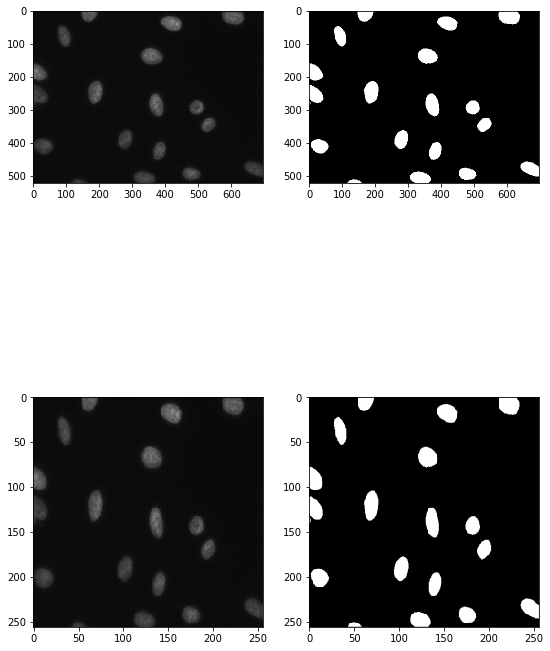

In [15]:

def evaluateImage(imageID, model=None):
    plt.figure(figsize=(14,14))

    img = getFileImage(fileIDs[imageID])
    plt.subplot(231)
    plt.grid(False)
    plt.imshow(img, cmap='gray')
    plt.subplot(234)
    plt.grid(False)
    plt.imshow(imgResize(img, (unetSize,unetSize)), cmap='gray')

    if model is not None:
        pred = model.predict(imgResize(img,(unetSize,unetSize))[newaxis,:,:,:3])[0,:,:,0]
        print(pred.shape)
        plt.subplot(233)
        plt.grid(False)
        plt.imshow(pred, cmap='gray')
        plt.subplot(236)
        plt.grid(False)
        plt.imshow(imgResize(pred, (unetSize,unetSize)), cmap='gray')
    
    img = getFileMasks(fileIDs[imageID])
    plt.subplot(232)
    plt.grid(False)
    plt.imshow(img, cmap='gray')
    plt.subplot(235)
    plt.grid(False)
    plt.imshow(imgResize(img,(unetSize,unetSize)), cmap='gray')
    


evaluateImage(35)

In [16]:
if os.path.isfile('data/inputImg.npy'):
    inputImg = np.load('data/inputImg.npy')
    masks = np.load('data/masks.npy')
else:
    inputImg = []
    masks = []
    for fileId in fileIDs:
        print('.', end ='')
        inputImg.append(imgResize(getFileImage(fileId), (unetSize, unetSize)))
        masks.append(imgResize(getFileMasks(fileId), (unetSize, unetSize)))
    inputImg = np.stack(inputImg)
    masks = np.stack(masks)
    masks = masks[:,:,:, newaxis]
    np.save('data/masks.npy', masks)
    np.save('data/inputImg.npy', inputImg)

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [17]:
# !rm data/*.npy

In [18]:
inputImg.shape

(670, 256, 256, 4)

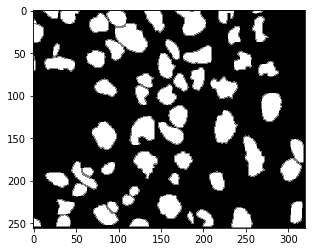

In [19]:
fileID = fileIDs[0]
plt.grid(False)
mask = getFileMasks(fileID)
plt.imshow(mask, cmap = 'gray')

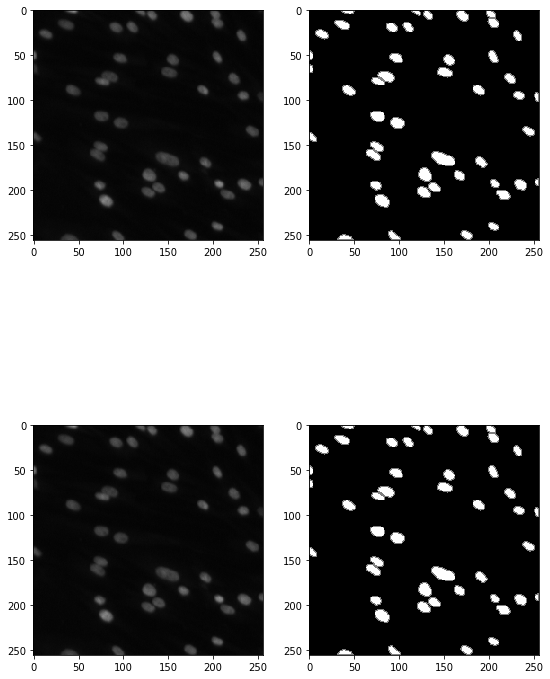

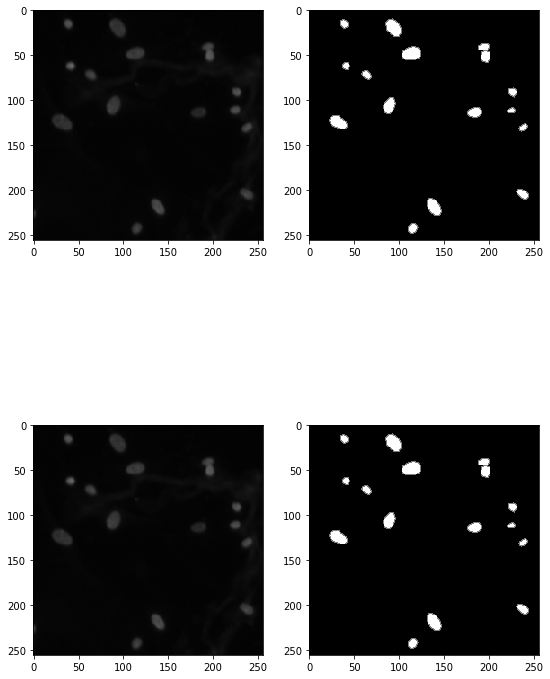

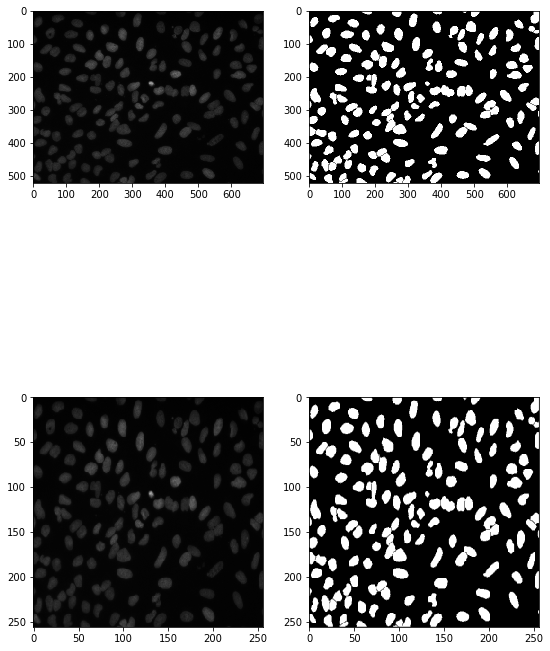

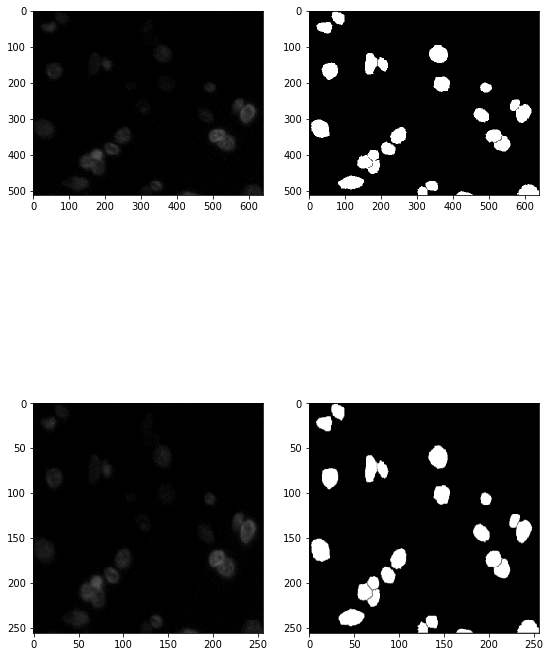

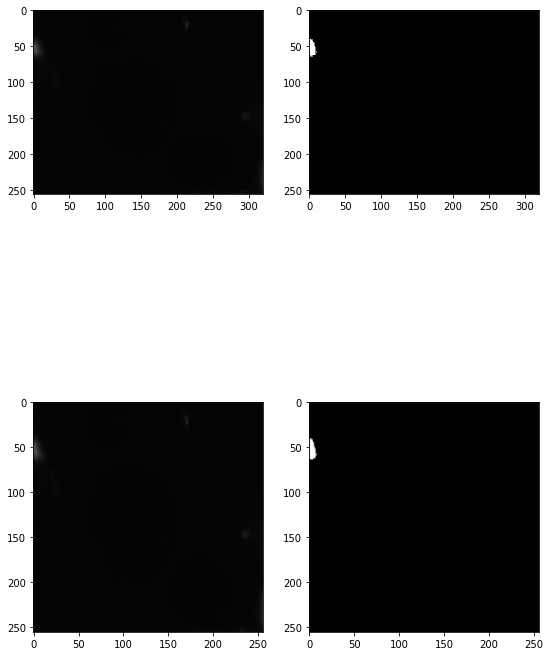

In [20]:
i = 5

for x in range(5):
    i = random.randint(0,len(fileIDs)-1)
    evaluateImage(i)

## U net

In [21]:
# inputImg = []
# masks = []

![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [22]:
# model PC1

In [23]:
imgsize = unetSize
inp = Input(shape=(imgsize,imgsize,3), name='input')

channels = 64
x = Conv2D(channels, (3,3), activation='relu', padding='same')(inp)
x_512 = Conv2D(channels, (3,3), activation='relu', padding='same')(x)

x = MaxPooling2D(pool_size=(2, 2), padding='same')(x_512)

channels = 128
x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
x_256 = Conv2D(channels, (3,3), activation='relu', padding='same')(x)



channels = channels * 2
x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
x_128 = Conv2D(channels, (3,3), activation='relu', padding='same')(x)


x = UpSampling2D((2, 2))(x_256)

c = concatenate([x_512,x])

x = Conv2D(channels, (3,3), activation='relu', padding='same')(c)
channels =64
x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)

out = Conv2D(1, (1,1), activation='sigmoid', padding='same')(x)


unetAE = Model(inp,out)
unetAE.compile(optimizer='adadelta', loss='binary_crossentropy')

unetAE.summary()


# x = MaxPooling2D(pool_size=(2, 2), padding='same')(x_128)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 64)  1792        input[0][0]                      
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 256, 256, 64)  36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 128, 128, 64)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [28]:
# Model PC2

imgsize = unetSize

def uconvx2(x, channels):
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
    return x

def uConvDown(x, channels):
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = uconvx2(x, channels)
    return x

def uConvUp(x, grey, channels):
    x = UpSampling2D((2, 2))(x)
    x = uconvx2(concatenate([x,grey]), channels)
    return x

inp = Input(shape=(imgsize,imgsize,3), name='input')

startChannel = 64
numChannels = 4
layer = []

layer.append(uconvx2(inp, startChannel))
for i in range(1, numChannels+1):
    layer.append(uConvDown(layer[-1],startChannel*(2**i)))

middle = layer[-1]

for i in range(numChannels+1,1,-1):
    layer.append(uConvUp(layer[-1], layer[i-2], startChannel*(2**i)))

out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(layer[-1])


mid = Model(inp, middle)
unetAE = Model(inp,out)
unetAE.compile(optimizer='adadelta', loss='binary_crossentropy')

unetAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_30 (Conv2D)               (None, 256, 256, 64)  1792        input[0][0]                      
____________________________________________________________________________________________________
conv2d_31 (Conv2D)               (None, 256, 256, 64)  36928       conv2d_30[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)   (None, 128, 128, 64)  0           conv2d_31[0][0]                  
___________________________________________________________________________________________

In [29]:

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        ;
#         self.initVars()

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
#         self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(16,10))
        ax = plt.subplot(133)
        self.plotLosses(ax)
#         self.plotProgress(ax)
        plt.show()

    def plotLosses(self, ax):
        plt.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        plt.plot(np.arange(len(self.losses)), self.val_losses, label="val loss")
#         plt.plot(self.x, self.losses, label="train loss")
#         plt.plot(self.x, self.val_losses, label="val loss")
        # ax.set_yscale("log", nonposy='clip')
        plt.legend()
        
#     def plotProgress(self, ax):
#         imgid = df.SDSS_ID.values[random.randint(0, df.shape[0]-1)]

#         testimg = img_preproc(imgid,curPreProc)
#         testimga = testimg[newaxis, :,:,newaxis]

#         plt.subplot(231)
#         plt.title(str(imgid))
#         plt.imshow(testimg)
#         plt.subplot(232)
#         plt.title('U-AE')
#         plt.imshow(unetAE.predict(testimga)[0,:,:,0])
#         plt.subplot(234)
#         plt.title( 'hackaton')
#         testimg = img_preproc(imgid,curPreProc+128)
#         plt.imshow(testimg)
#         if os.path.isfile('data/mainData/'+str(imgid)+'.npy'):
#             X = np.load('data/mainData/'+str(imgid)+'.npy')
#             X = img_preprocnoread(X, curPreProc)
#             plt.subplot(235)
#             plt.title('other cleanup')
#             plt.imshow(X)
        
        
myPlotLosses = PlotLosses()
# myPlotLosses.initVars()

In [26]:
from IPython.display import clear_output

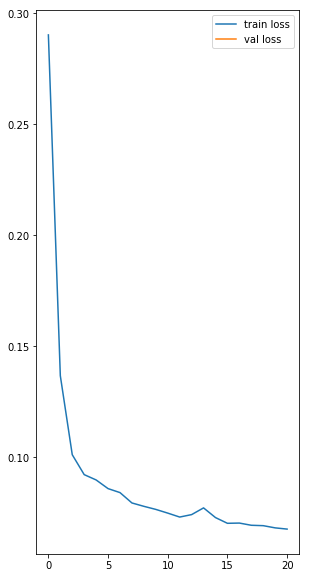

670/670 [==============================] - 179s - loss: 0.0676   
Epoch 22/50
  9/670 [..............................] - ETA: 177s - loss: 0.0923

KeyboardInterrupt: 

In [30]:
batchSize = 3
for i in range(0, len(inputImg), 20) :
#     x_train = inputImg[i: (i + 20)][:,:,:,:3]/255.0
#     y_train = masks[i: (i + 20)]/255.0
#     unetAE.fit(x_train, y_train,
    unetAE.fit(inputImg[:,:,:,:3]/255.0, masks/255.0,
                epochs=50,
                batch_size=batchSize,
                shuffle=True,
#                 validation_data=(x_test, x_test),
                    verbose=1
                ,callbacks=[myPlotLosses]
              )

In [ ]:
pred = unetAE.predict(inputImg[570:575][:,:,:,:3])

(256, 256)


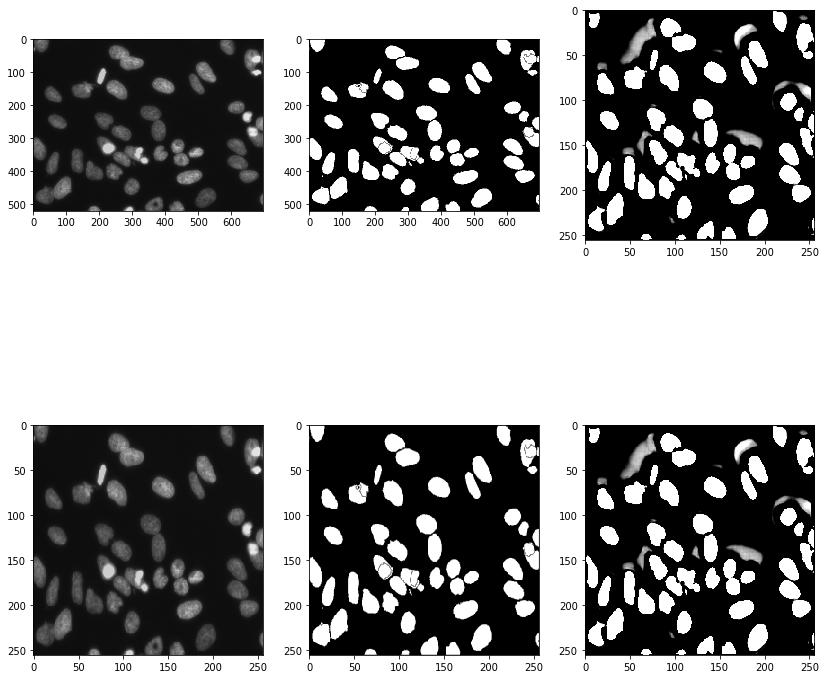

In [37]:
evaluateImage(650, unetAE)

In [ ]:
testIDs

In [ ]:
# testIDs = fileIDs[0:3]
model = unetAE

In [ ]:
encodedPredictions = {}
for fileID in testIDs:
    img = getFileImage(fileID, testDir)
    pred = model.predict(imgResize(img,(512,512))[newaxis,:,:,:3])[0,:,:,0]
    print(img.shape, img.shape[:2])
    pred = np.round(imgResize(pred, img.shape[:2]) ) * 255
    plt.imshow(pred, cmap = 'gray')
    encodedPredictions[fileID] = getSubmissionForFile(fileID,splitMask(pred))
#     break
    
encodedPredictions    

In [ ]:
plt.imshow(img)

In [ ]:
encodedPredictions.keys()

In [ ]:
from datetime import *
datetime.now()

In [ ]:
sub = pd.DataFrame(columns=['ImageId','EncodedPixels'])
print(len(sub))

for key,value in encodedPredictions.items():
    for nuclei in value:
        sub.loc[len(sub),:] = [key, ' '.join(map(str, nuclei))]

In [ ]:
filename = 'data/submission' + datetime.now().strftime('%Y-%m-%d_%H-%M')+ '.csv.gzip'

sub.to_csv(filename, compression='gzip', index=False)

In [ ]:
filename = 'data/submission' + datetime.now().strftime('%Y-%m-%d_%H-%M')+ '.csv'
file = open(filename,'w') 

file.write('ImageId\tEncodedPixels\n')
for key,value in encodedPredictions.items():
    for nuclei in value:
        file.write(key + '\t' + ' '.join(map(str, nuclei)) + '\n')
file.close() 



In [ ]:
!ls -al 'data/'